In [1]:
#Step 1 Data Preprocessing

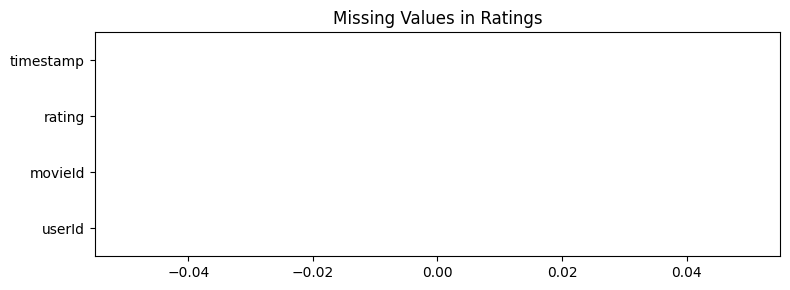

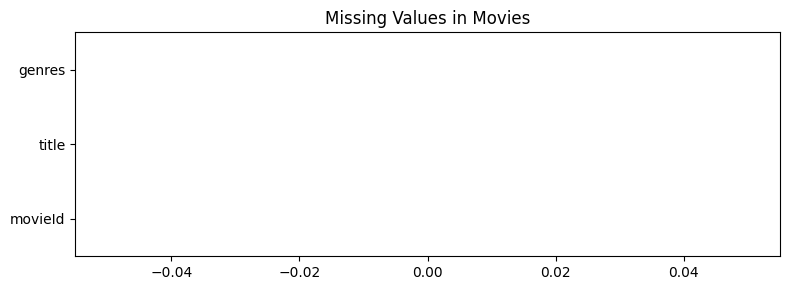

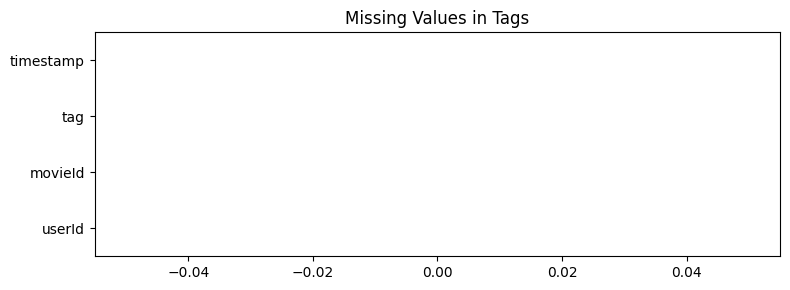

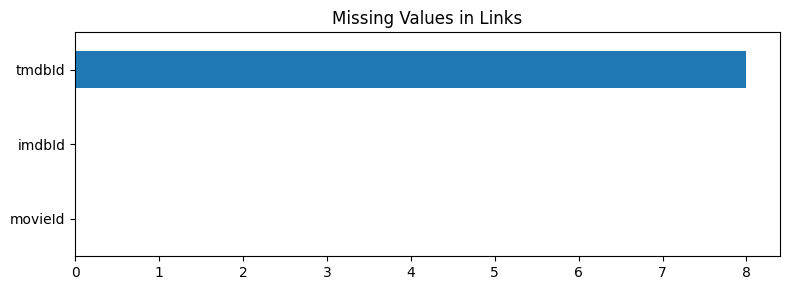

Duplicates in Ratings: 0
Duplicates in Movies: 0
Duplicates in Tags: 0
Duplicates in Links: 0


C:\Users\mr\AppData\Local\Temp\ipykernel_24820\3342036557.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  links_df["tmdbId"].fillna(-1, inplace=True)


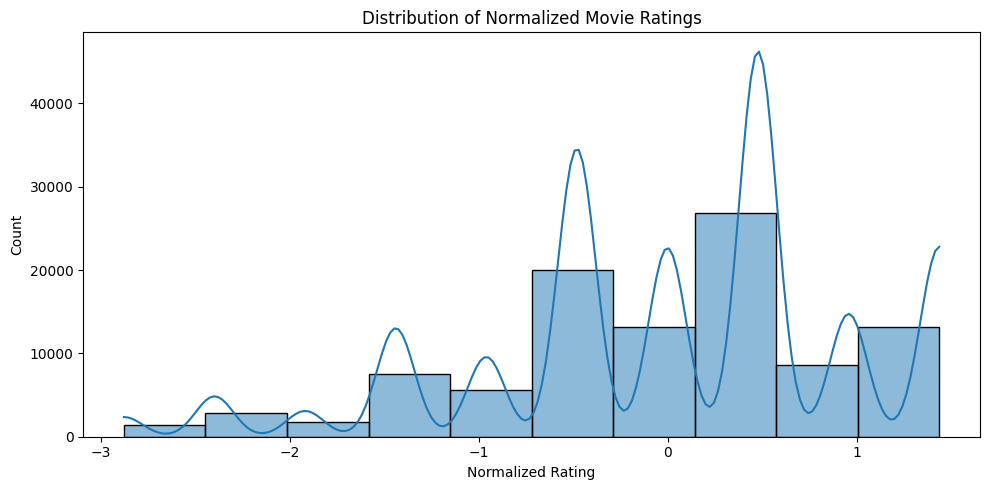

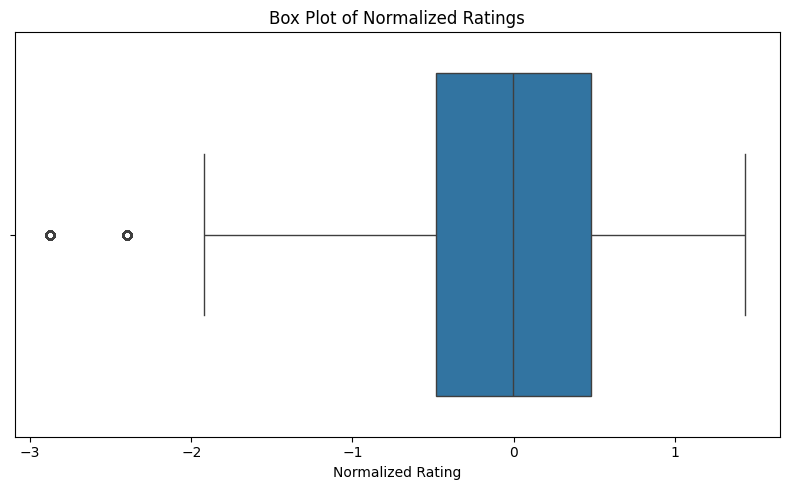

C:\Users\mr\AppData\Local\Temp\ipykernel_24820\3342036557.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")


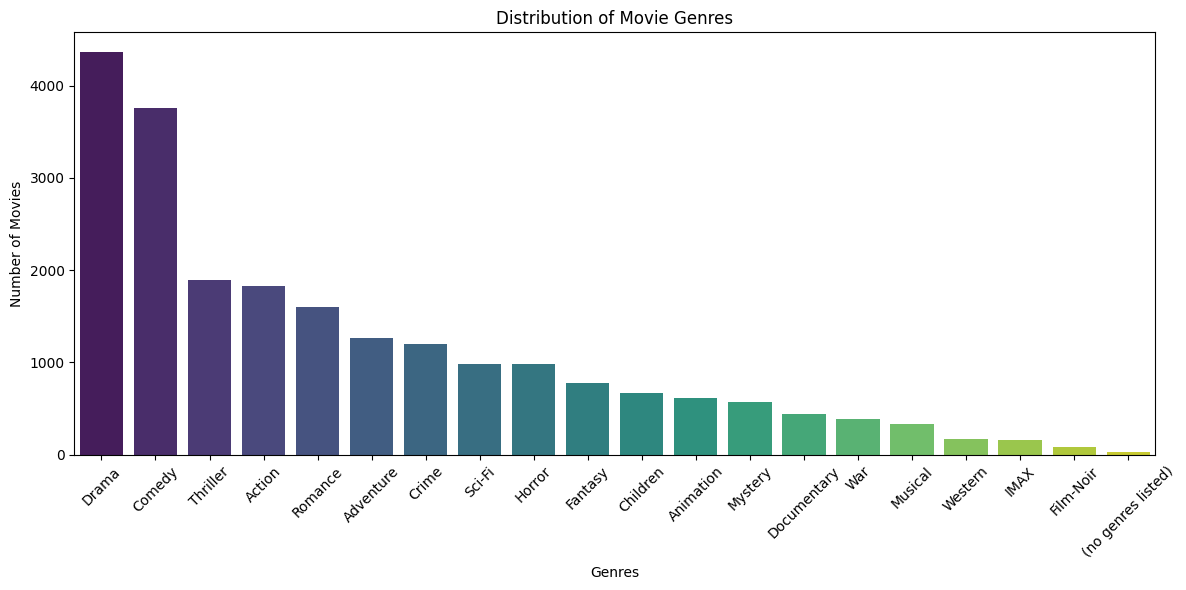

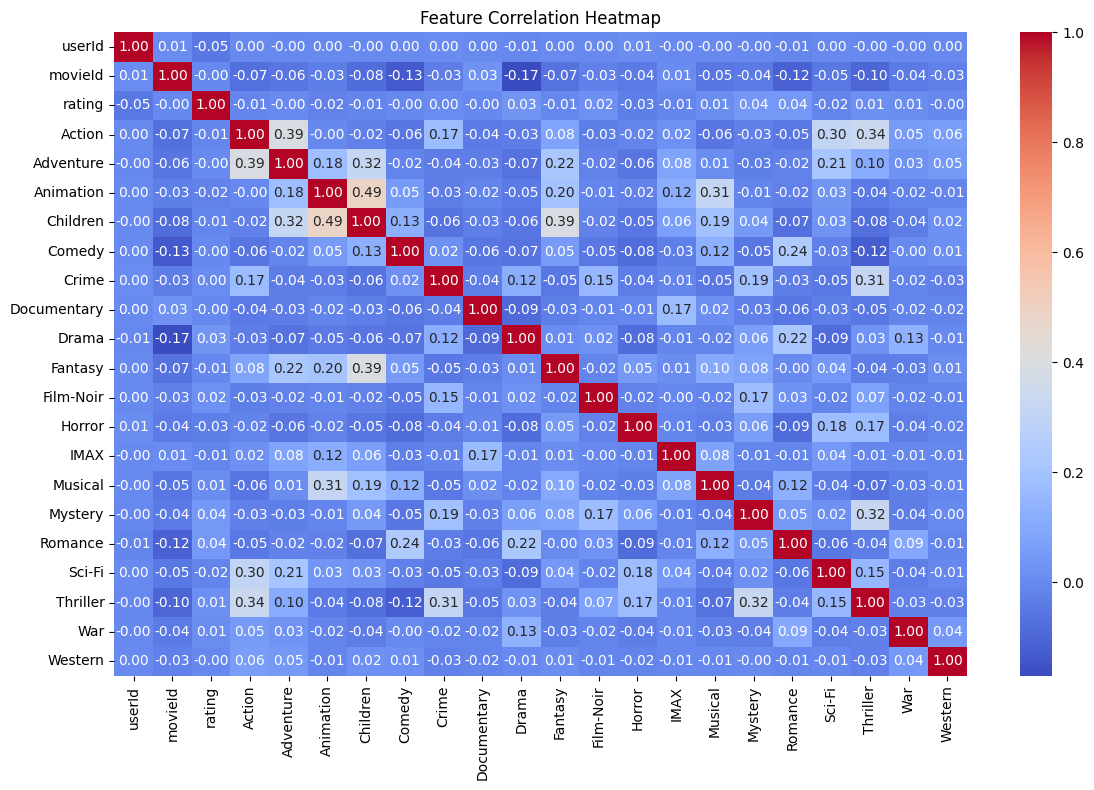

Ratings Dataset:
   userId  movieId    rating
0       1        1  0.478112
1       1        3  0.478112
2       1        6  0.478112
3       1       47  1.437322
4       1       50  1.437322
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int32  
 1   movieId  100836 non-null  int32  
 2   rating   100836 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 1.2 MB
None
              userId        movieId        rating
count  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718  5.750268e-09
std       182.618491   35530.987199  1.000005e+00
min         1.000000       1.000000 -2.879125e+00
25%       177.000000    1199.000000 -4.810987e-01
50%       325.000000    2991.000000 -1.493475e-03
75%       477.000000    8122.000000  4.781117e-01
max       610.000000  193609.000000  1.437322e+00

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler



# ---------------------- Step 1: Load Raw Data ----------------------

ratings_path = 'ratings.csv'
movies_path = 'movies.csv'
tags_path = 'tags.csv'
links_path = 'links.csv'

ratings_df = pd.read_csv(ratings_path)
movies_df = pd.read_csv(movies_path)
tags_df = pd.read_csv(tags_path)
links_df = pd.read_csv(links_path)

# ---------------------- Step 2: Preliminary Exploration ----------------------

# Checking missing values in each dataset
fig, ax = plt.subplots(figsize=(8, 3))
ratings_df.isna().sum().plot.barh(ax=ax)
ax.set_title("Missing Values in Ratings")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
movies_df.isna().sum().plot.barh(ax=ax)
ax.set_title("Missing Values in Movies")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
tags_df.isna().sum().plot.barh(ax=ax)
ax.set_title("Missing Values in Tags")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
links_df.isna().sum().plot.barh(ax=ax)
ax.set_title("Missing Values in Links")
plt.tight_layout()
plt.show()

# Checking for duplicates in each dataset
print("Duplicates in Ratings:", ratings_df.duplicated().sum())
print("Duplicates in Movies:", movies_df.duplicated().sum())
print("Duplicates in Tags:", tags_df.duplicated().sum())
print("Duplicates in Links:", links_df.duplicated().sum())

# ---------------------- Step 3: Preprocess Data ----------------------

# Handling missing values
# For links, replace missing tmdbId with -1 to indicate an uknown/missing id 
links_df["tmdbId"].fillna(-1, inplace=True)


#Optimize Data Types for reducing  memory usage 
ratings_df = ratings_df.astype({"userId": "int32", "movieId": "int32", "rating": "float32"})
links_df = links_df.astype({"movieId": "int32", "imdbId": "int32", "tmdbId": "int32"})


#Remove Unnecessary Columns, timestamp, title is not  useful for our  analysis 
ratings_df.drop(columns=["timestamp"], inplace=True)
tags_df.drop(columns=["timestamp"], inplace=True)
movies_df.drop(columns=["title"], inplace=True)


# this step Ensures data integrity (handling missing IDs), lowers memory usage, and removes columns that don’t contribute to your analysis or models.

# ---------------------- Step 4: Process Genres ----------------------

# Convert the genres string into lists
movies_df["genres"] = movies_df["genres"].str.split("|")
# Explode the genres so that each genre appears in its own row
genres_exploded = movies_df.explode("genres")
# Create one-hot encoding for genres
genres_one_hot = pd.get_dummies(genres_exploded["genres"], dtype=int)
# Aggregate back to one row per movie using max (1 if the genre appears)
movies_df_encoded = movies_df.drop(columns=["genres"]).join(
    genres_one_hot.groupby(genres_exploded["movieId"]).max()
)

# One-hot encoding makes genres numeric, enabling distance calculations for clustering purposes or serving as features for classification.

# ---------------------- Step 5: Normalize Ratings ----------------------

scaler = StandardScaler()
ratings_df["rating"] = scaler.fit_transform(ratings_df[["rating"]])

#Merge Ratings with Movies for Further Analysis
ratings_with_genres = ratings_df.merge(movies_df_encoded, on="movieId", how="left")

#Transforming the rating column so it has mean=0 and standard deviation=1
#prevents features with larger ranges from dominating distance-based methods such as clustering.

# ---------------------- Step 6: Merge Datasets ----------------------

# Merge ratings with movies (with one-hot encoded genres)
ratings_with_genres = ratings_df.merge(movies_df_encoded, on="movieId", how="left")

# Optionally, if there are any missing values after merging, fill them with 0
ratings_with_genres.fillna(0, inplace=True)
movies_df_encoded.fillna(0, inplace=True)

# Remove a columns
ratings_with_genres.drop(columns=["(no genres listed)"], inplace=True)

#now we have a unified dataset
#(ratings_with_genres) that’s ready for exploratory analysis or modeling, containing both user rating behavior and movie attributes.


# ---------------------- Step 7: Exploratory Data Analysis ----------------------

# Histogram of normalized ratings
plt.figure(figsize=(10, 5))
sns.histplot(ratings_df["rating"], bins=10, kde=True)
plt.xlabel("Normalized Rating")
plt.ylabel("Count")
plt.title("Distribution of Normalized Movie Ratings")
plt.tight_layout()
plt.show()

# Box Plot of ratings to inspect spread and outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=ratings_df["rating"])
plt.xlabel("Normalized Rating")
plt.title("Box Plot of Normalized Ratings")
plt.tight_layout()
plt.show()

# Genre Distribution
genre_counts = genres_exploded["genres"].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
plt.xlabel("Genres")
plt.ylabel("Number of Movies")
plt.title("Distribution of Movie Genres")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation heatmap on the merged dataset
plt.figure(figsize=(12, 8))
corr_matrix = ratings_with_genres.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# ---------------------- Step 8: Display Data Information ----------------------

print("Ratings Dataset:")
print(ratings_df.head())
print(ratings_df.info())
print(ratings_df.describe())

print("\nProcessed Movies Dataset with one-hot-encoded gneres:")
print(movies_df_encoded.head())
print(movies_df_encoded.info())
print(movies_df_encoded.describe())

print("\nMerged normalized Ratings with one-hot-encoded Movies Dataset:")
print(ratings_with_genres.head())
print(ratings_with_genres.info())
print(ratings_with_genres.describe())





In [3]:
#step2 clustering


Results for K=3:
  Silhouette Score: 0.38928328674944424
  Davies-Bouldin Index: 1.6919150123459978
  Calinski-Harabasz Index: 15170.347228061664


C:\Users\mr\AppData\Local\Temp\ipykernel_24820\3479705579.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


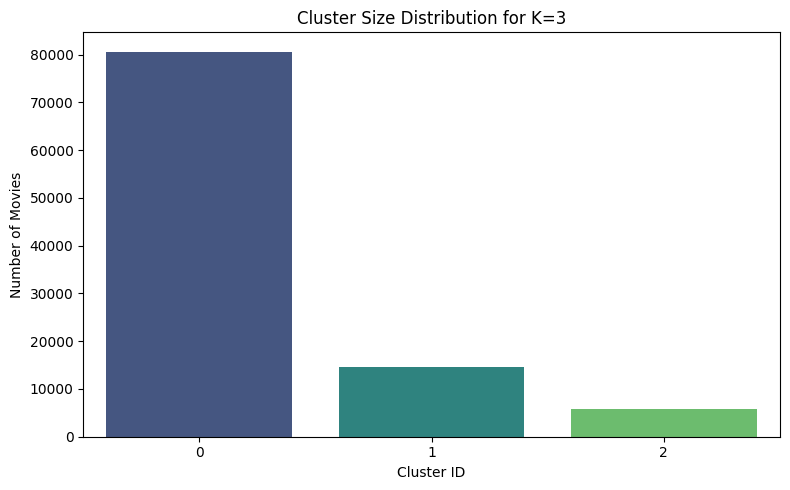


Results for K=4:
  Silhouette Score: 0.2701335934541642
  Davies-Bouldin Index: 1.6143443265426483
  Calinski-Harabasz Index: 14692.092598706102


C:\Users\mr\AppData\Local\Temp\ipykernel_24820\3479705579.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


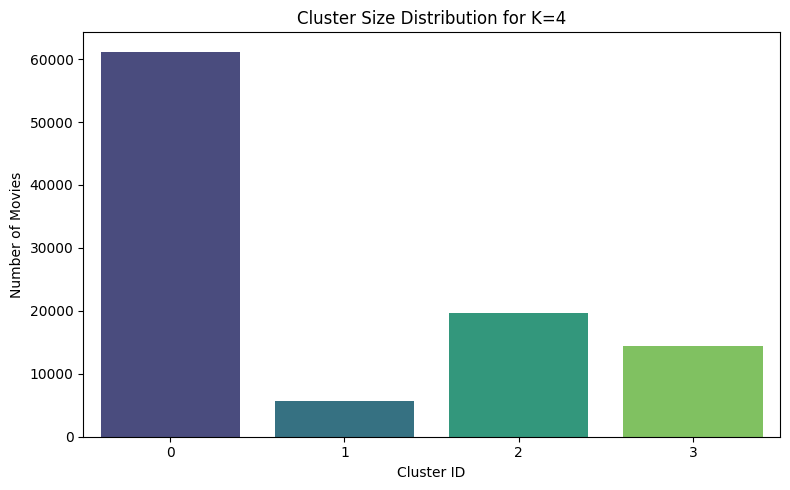


Results for K=5:
  Silhouette Score: 0.2845471991105408
  Davies-Bouldin Index: 1.406902079147287
  Calinski-Harabasz Index: 15017.776516942524


C:\Users\mr\AppData\Local\Temp\ipykernel_24820\3479705579.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


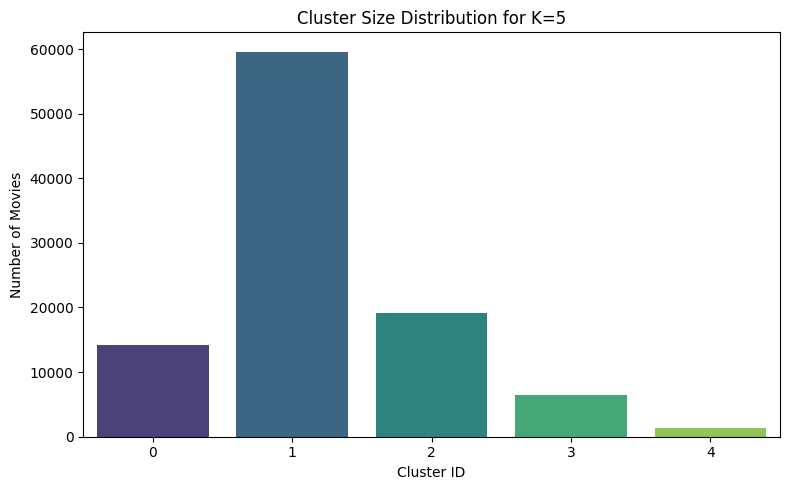


Results for K=6:
  Silhouette Score: 0.3023753462281525
  Davies-Bouldin Index: 1.3065764622140434
  Calinski-Harabasz Index: 15556.29225884428


C:\Users\mr\AppData\Local\Temp\ipykernel_24820\3479705579.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


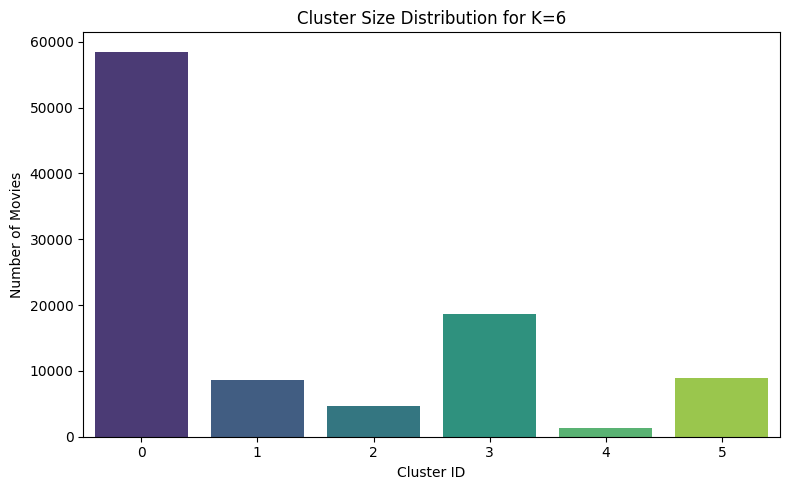


Results for K=7:
  Silhouette Score: 0.3300266648960998
  Davies-Bouldin Index: 1.205751111694503
  Calinski-Harabasz Index: 16243.23256904165


C:\Users\mr\AppData\Local\Temp\ipykernel_24820\3479705579.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


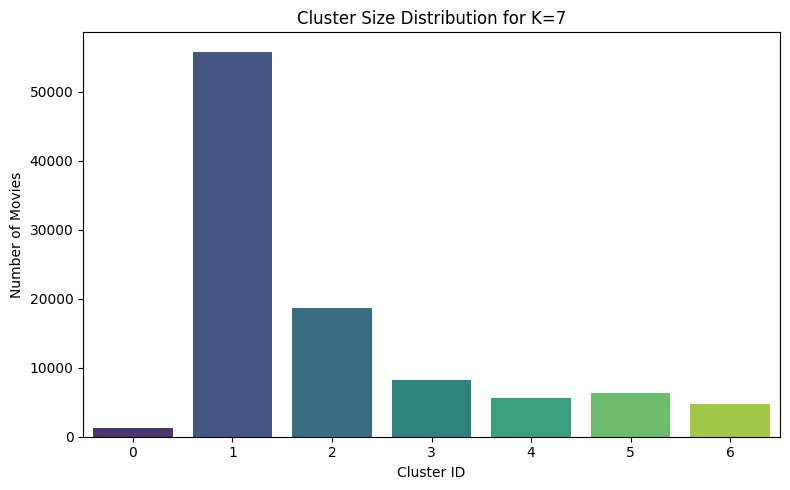


Results for K=8:
  Silhouette Score: 0.33555468788915566
  Davies-Bouldin Index: 1.2441047541375574
  Calinski-Harabasz Index: 16028.242868663088


C:\Users\mr\AppData\Local\Temp\ipykernel_24820\3479705579.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


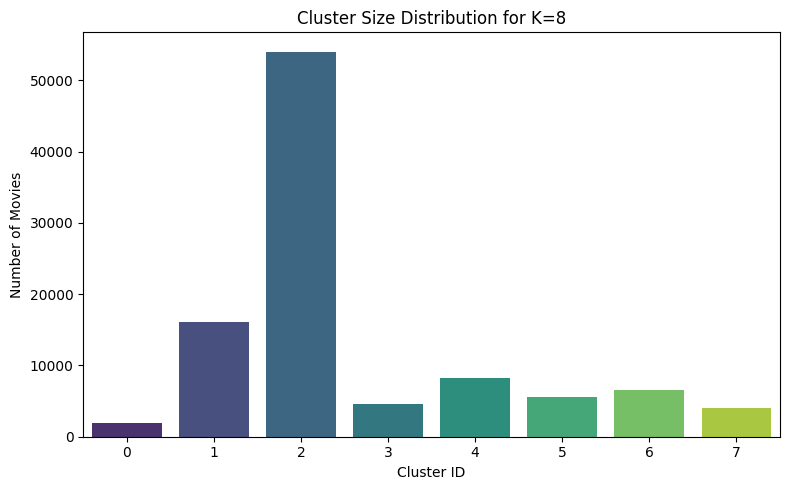

KeyboardInterrupt: 

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

# ---------------------- Step 1: Prepare Features ----------------------
# Assume ratings_with_genres is your preprocessed merged DataFrame.
# Remove non-feature columns that are not useful for clustering.
features = ratings_with_genres.drop(columns=['movieId', 'userId'], errors='ignore')

# Scale the features using StandardScaler.
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)



# ---------------------- Step 2: Dimensionality Reduction with PCA ----------------------
# Reduce dimensionality to 10 components for faster clustering and improved performance.
#In high-dimensional spaces, distance metrics can become less meaningful.

pca = PCA(n_components=10)
features_reduced = pca.fit_transform(features_scaled)

# ---------------------- Step 3: Finding the Optimal K for K-Means ----------------------
K_range = range(3, 11)
inertia = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
cluster_distributions = {}

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_reduced)
    
    #collecting metrics
    inertia.append(kmeans.inertia_)
    sil_score = silhouette_score(features_reduced, labels)
    silhouette_scores.append(sil_score)
    davies_score = davies_bouldin_score(features_reduced, labels)
    davies_bouldin_scores.append(davies_score)
    ch_score = calinski_harabasz_score(features_reduced, labels)
    calinski_harabasz_scores.append(ch_score)
    
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    cluster_distributions[k] = cluster_counts
    
    #printing results for each K
    print(f"\nResults for K={k}:")
    print(f"  Silhouette Score: {sil_score}")
    print(f"  Davies-Bouldin Index: {davies_score}")
    print(f"  Calinski-Harabasz Index: {ch_score}")
    
    #bar plot showing how many points fall into each cluster
    plt.figure(figsize=(8, 5))
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Movies")
    plt.title(f"Cluster Size Distribution for K={k}")
    plt.tight_layout()
    plt.show()

# Plot evaluation metrics
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', label="Inertia")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--', color='red', label="Silhouette Score")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different K Values")
plt.legend()
plt.tight_layout()
plt.show()

#These plots help visually determine a good K. If there’s a clear elbow or a peak in silhouette, that’s often a good candidate.

# Select the best K based on maximum silhouette score using the reduced features.
best_k = max(K_range, key=lambda k: silhouette_score(features_reduced, 
              KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(features_reduced)))
best_k=5
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_reduced)

# For visualization, reduce the dimensionality to 2 components.
pca_viz = PCA(n_components=2)
features_pca = pca_viz.fit_transform(features_reduced)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=kmeans_labels, 
                palette="viridis", s=50)
plt.title(f"Final K-Means Clustering (K={best_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# ---------------------- Step 4: DBSCAN Optimization ----------------------
eps_values = [0.3, 0.4, 0.5]
min_samples_values = [4, 5, 6]
best_eps, best_min_samples, best_silhouette = None, None, -1
dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(features_reduced)
        
        if len(set(labels)) > 1:
            sil_score = silhouette_score(features_reduced, labels)
            davies_score = davies_bouldin_score(features_reduced, labels)
            ch_score = calinski_harabasz_score(features_reduced, labels)
            outliers = np.sum(labels == -1)
            
            dbscan_results.append((eps, min_samples, sil_score, davies_score, ch_score, outliers))
            if sil_score > best_silhouette:
                best_silhouette = sil_score
                best_eps, best_min_samples = eps, min_samples

#A good silhouette can indicate that DBSCAN is finding meaningful clusters (instead of labeling most points as outliers).


print(f"\nBest DBSCAN Parameters: eps={best_eps}, min_samples={best_min_samples}, Silhouette={best_silhouette}")

dbscan_opt = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels_opt = dbscan_opt.fit_predict(features_reduced)

#visualizing dbscan clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=dbscan_labels_opt, 
                palette="coolwarm", s=50)
plt.title(f"DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()



In [5]:
ratings_with_genres['kmeans_cluster'] = kmeans_labels
ratings_with_genres['dbscan_cluster'] = dbscan_labels_opt

In [6]:
kmeans_labels
print("K-Means Cluster Distribution:")
print(ratings_with_genres['kmeans_cluster'].value_counts().sort_index())


K-Means Cluster Distribution:
kmeans_cluster
0    14178
1    59602
2    19211
3     6518
4     1327
Name: count, dtype: int64


In [7]:
dbscan_labels_opt
print("\nDBSCAN Cluster Distribution:")
print(ratings_with_genres['dbscan_cluster'].value_counts().sort_index())


DBSCAN Cluster Distribution:
dbscan_cluster
-1       2647
 0       8537
 1         54
 2       1685
 3       1511
         ... 
 1712       5
 1713       4
 1714       4
 1715       4
 1716       4
Name: count, Length: 1718, dtype: int64


K-Means Cluster Distribution:
kmeans_cluster
0    14178
1    59602
2    19211
3     6518
4     1327
Name: count, dtype: int64

DBSCAN Cluster Distribution:
dbscan_cluster
-1       2647
 0       8537
 1         54
 2       1685
 3       1511
         ... 
 1712       5
 1713       4
 1714       4
 1715       4
 1716       4
Name: count, Length: 1718, dtype: int64

K-Means Cluster Profiles (Mean Values):
                    userId       movieId    rating    Action  Adventure  \
kmeans_cluster                                                            
0               326.071590  11791.009945  0.027158  0.511285   0.241219   
1               326.735646  25543.408896 -0.012196  0.018489   0.011493   
2               323.804799  10246.433137  0.048811  0.034251   0.033210   
3               327.058147   9055.828168 -0.083096  0.156643   0.488033   
4               328.469480  10773.299171 -0.040888  0.257724   0.195931   

                Animation  Children    Comedy     Crime  Documentary

C:\Users\mr\AppData\Local\Temp\ipykernel_24820\1898315461.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='kmeans_cluster', y='rating', data=ratings_with_genres, palette="viridis")


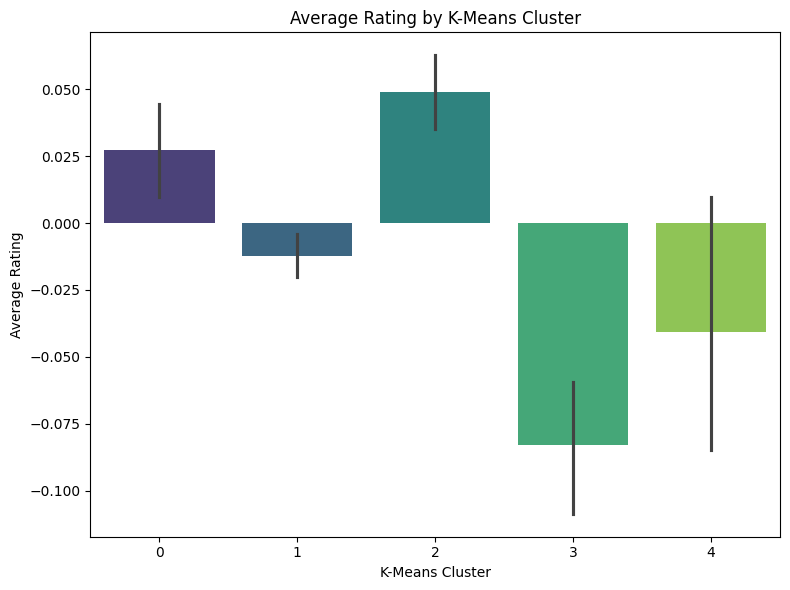

C:\Users\mr\AppData\Local\Temp\ipykernel_24820\1898315461.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='kmeans_cluster', y=genre, data=cluster_genre_mean, palette="magma")


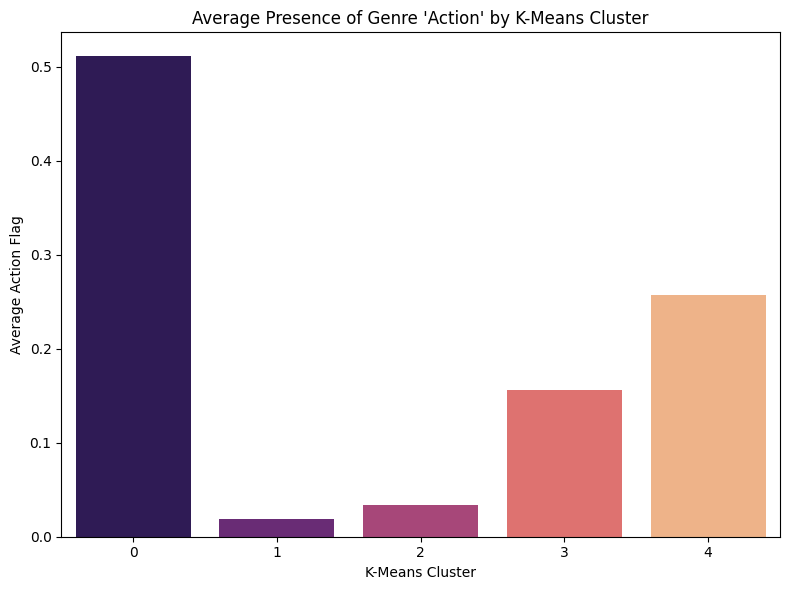

C:\Users\mr\AppData\Local\Temp\ipykernel_24820\1898315461.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='kmeans_cluster', y=genre, data=cluster_genre_mean, palette="magma")


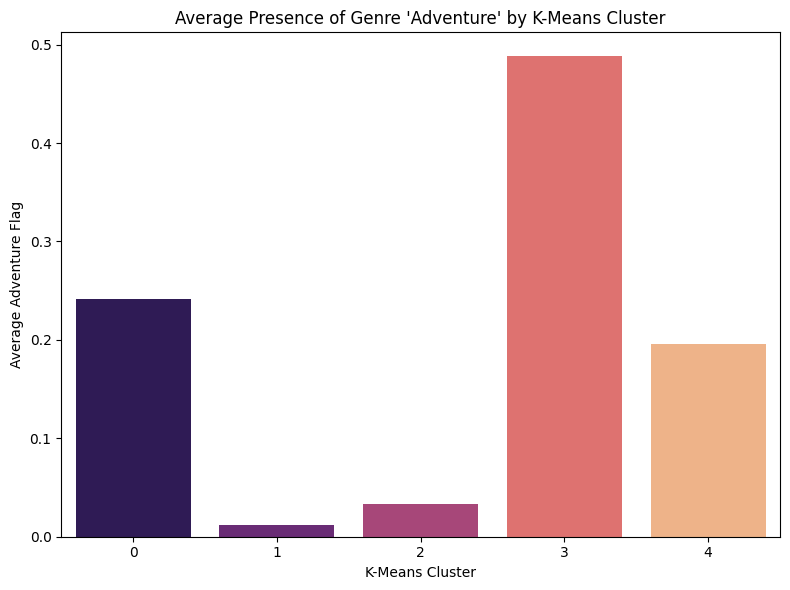

C:\Users\mr\AppData\Local\Temp\ipykernel_24820\1898315461.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='kmeans_cluster', y=genre, data=cluster_genre_mean, palette="magma")


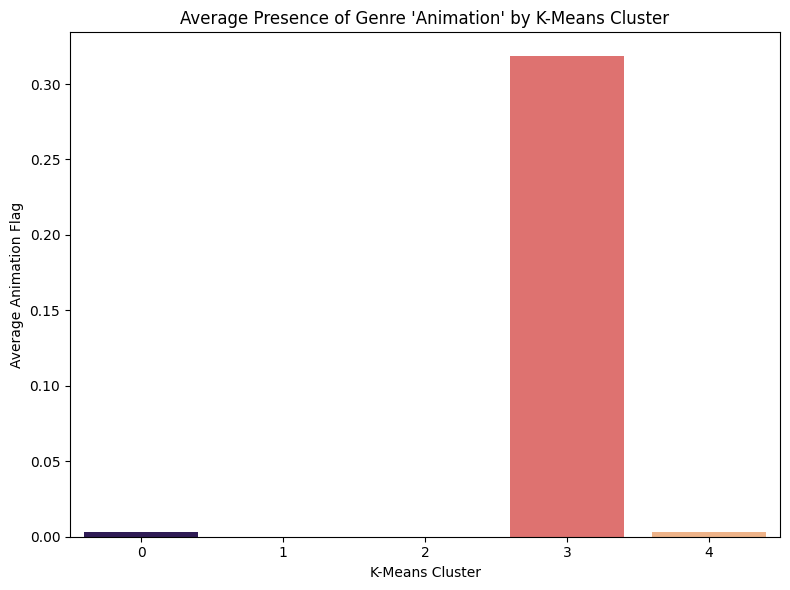

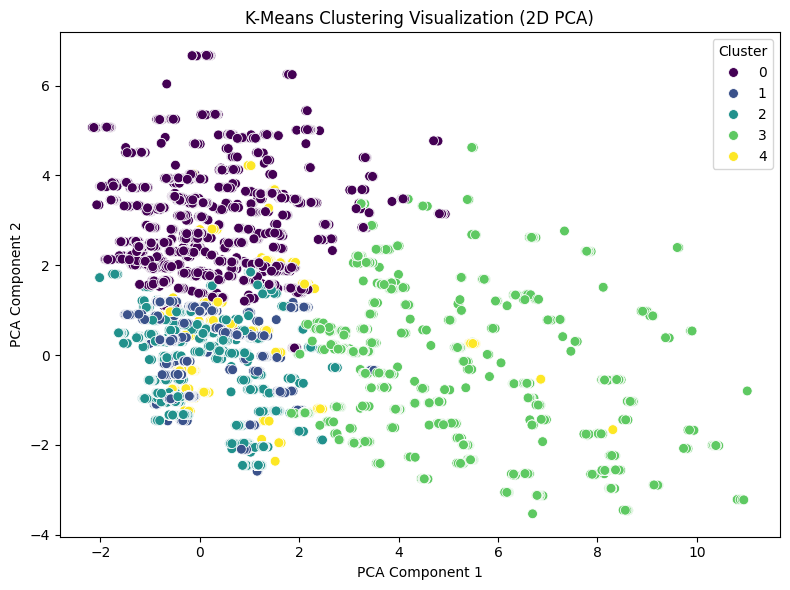

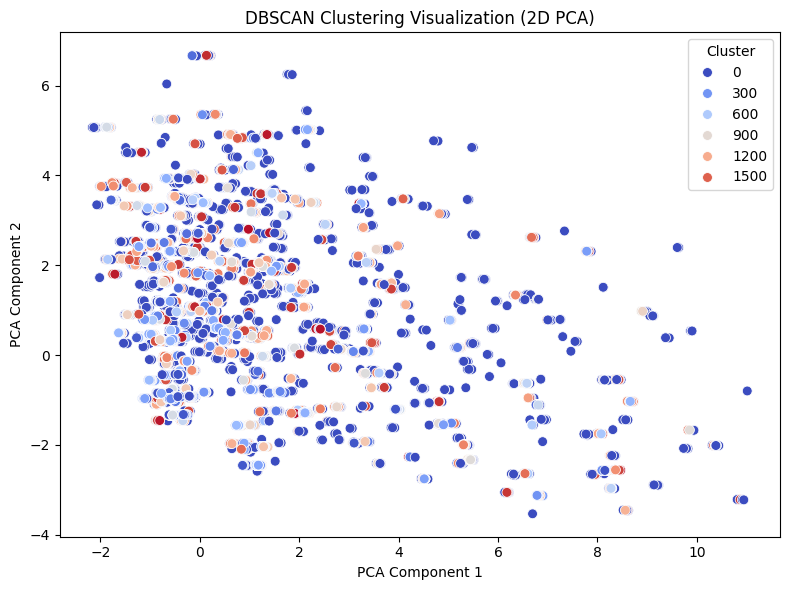

In [8]:
# ---------------------- Cluster Profiling  ----------------------

# - kmeans_labels is obtained from K-Means clustering
# - dbscan_labels_opt is obtained from DBSCAN clustering

# 1. Attach Cluster Labels to the DataFrame
ratings_with_genres['kmeans_cluster'] = kmeans_labels
ratings_with_genres['dbscan_cluster'] = dbscan_labels_opt

# 2. Print Cluster Distribution for Both Methods
print("K-Means Cluster Distribution:")
print(ratings_with_genres['kmeans_cluster'].value_counts().sort_index())

print("\nDBSCAN Cluster Distribution:")
print(ratings_with_genres['dbscan_cluster'].value_counts().sort_index())

# 3. Compute Descriptive Statistics per Cluster
print("\nK-Means Cluster Profiles (Mean Values):")
kmeans_profiles = ratings_with_genres.groupby('kmeans_cluster').mean()
print(kmeans_profiles)

print("\nDBSCAN Cluster Profiles (Mean Values):")
dbscan_profiles = ratings_with_genres.groupby('dbscan_cluster').mean()
print(dbscan_profiles)

# 4. (Optional) Profile Genre Distributions
# Assuming your one-hot encoded genre columns are present in ratings_with_genres.
# Here, we define genre columns as those with exactly 2 unique values (0 and 1)
non_genre_cols = {'movieId', 'userId', 'rating', 'kmeans_cluster', 'dbscan_cluster'}
genre_cols = [col for col in ratings_with_genres.columns 
              if col not in non_genre_cols and ratings_with_genres[col].nunique() == 2]

print("\nK-Means Genre Distributions (Count per Cluster):")
kmeans_genres = ratings_with_genres.groupby('kmeans_cluster')[genre_cols].sum()
print(kmeans_genres)

print("\nDBSCAN Genre Distributions (Count per Cluster):")
dbscan_genres = ratings_with_genres.groupby('dbscan_cluster')[genre_cols].sum()
print(dbscan_genres)

# 5. Visualize Cluster Profiles

# 5.1 Average Rating by Cluster (K-Means)
plt.figure(figsize=(8, 6))
sns.barplot(x='kmeans_cluster', y='rating', data=ratings_with_genres, palette="viridis")
plt.title("Average Rating by K-Means Cluster")
plt.xlabel("K-Means Cluster")
plt.ylabel("Average Rating")
plt.tight_layout()
plt.show()

# 5.2 Genre Distribution Example for a Few Genres (K-Means)
# Plot the average presence (or count) of a few genres per cluster.
# You can loop over all genres or select a few.
selected_genres = genre_cols[:3]  # Example: first three genre columns
for genre in selected_genres:
    plt.figure(figsize=(8, 6))
    # Calculate the average presence of the genre in each cluster.
    cluster_genre_mean = ratings_with_genres.groupby('kmeans_cluster')[genre].mean().reset_index()
    sns.barplot(x='kmeans_cluster', y=genre, data=cluster_genre_mean, palette="magma")
    plt.title(f"Average Presence of Genre '{genre}' by K-Means Cluster")
    plt.xlabel("K-Means Cluster")
    plt.ylabel(f"Average {genre} Flag")
    plt.tight_layout()
    plt.show()

# 5.3 Visualize Clusters on a 2D PCA Projection
# For visualization, we use PCA to project the scaled features into 2D space.
# (Assuming features_scaled exists from the preprocessing stage)
pca_viz = PCA(n_components=2)
features_2d = pca_viz.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=ratings_with_genres['kmeans_cluster'], 
                palette="viridis", s=50)
plt.title("K-Means Clustering Visualization (2D PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# Similarly, you can visualize DBSCAN clusters:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=ratings_with_genres['dbscan_cluster'], 
                palette="coolwarm", s=50)
plt.title("DBSCAN Clustering Visualization (2D PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


Target Label Distribution (0 = Not Popular, 1 = Popular):
is_popular
0.0    6797
1.0    2945
Name: count, dtype: int64

=== SVM Evaluation ===
SVM Accuracy: 0.7599
              precision    recall  f1-score   support

         0.0       0.99      0.67      0.79      1360
         1.0       0.56      0.98      0.71       589

    accuracy                           0.76      1949
   macro avg       0.77      0.82      0.75      1949
weighted avg       0.86      0.76      0.77      1949



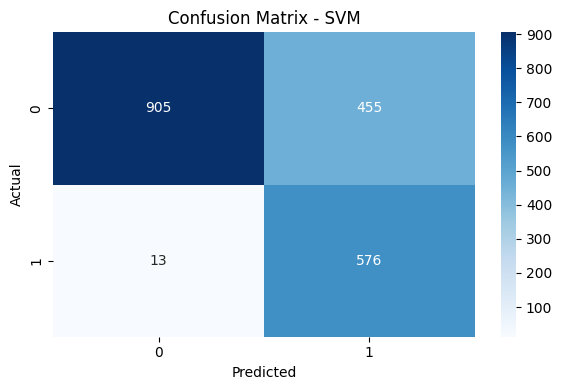

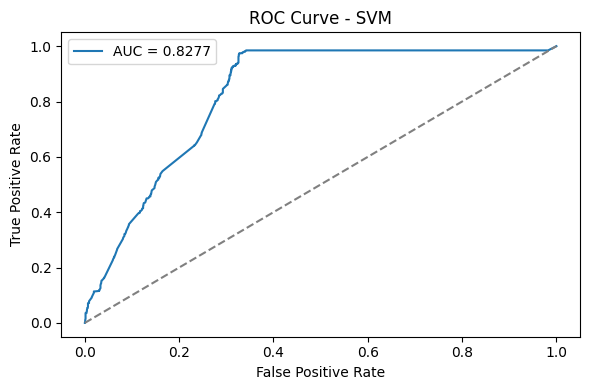

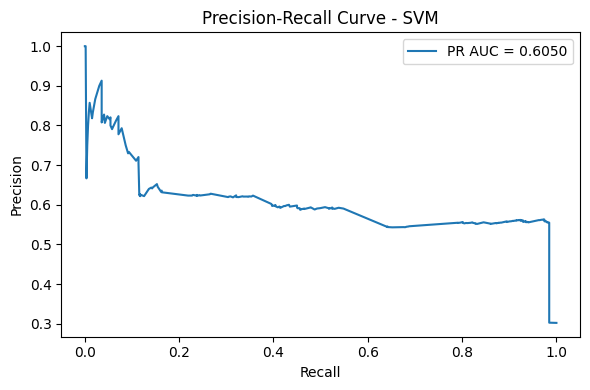


=== Neural Network Evaluation ===
Neural Network Accuracy: 0.7768
              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84      1360
         1.0       0.62      0.68      0.65       589

    accuracy                           0.78      1949
   macro avg       0.74      0.75      0.74      1949
weighted avg       0.78      0.78      0.78      1949



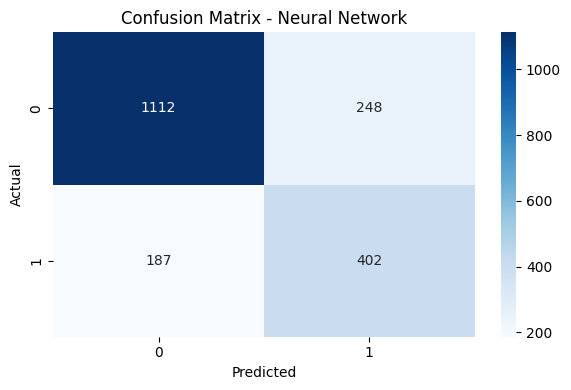

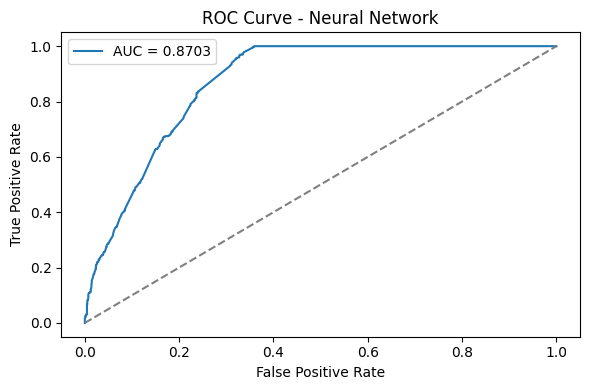

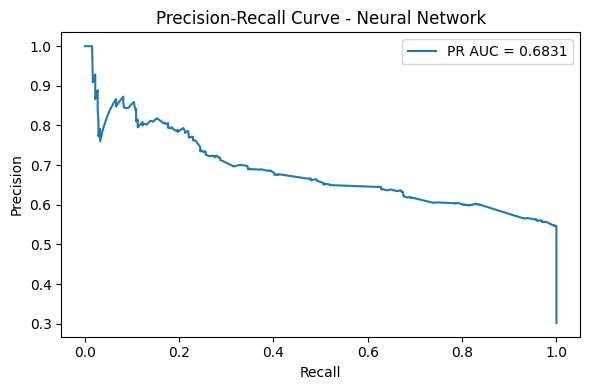

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler

# ---------------------- Step 3: Classification - Predicting Movie Popularity ----------------------
# Define target variable 'is_popular' for each movie.
# We use the count of ratings per movie, and label a movie as popular (1) if its count is above the median, otherwise 0.
ratings_count = ratings_df.groupby('movieId')['rating'].count()
movies_df['is_popular'] = (ratings_count > ratings_count.median()).astype(int)

#This binary label (is_popular) is the classification target. we will train supervised models to predict which movies are likely to be popular.

# Merge the movie features (one-hot encoded genres in movies_df_encoded) with the popularity label.
movies_with_features = movies_df_encoded.merge(movies_df[['movieId', 'is_popular']], on='movieId', how='left')
movies_with_features.fillna(0, inplace=True) #filling any missing valued with zero

# Prepare the dataset for classification:
# X: Features (drop non-feature columns like movieId and is_popular)
# y: Target variable (is_popular)
X = movies_with_features.drop(columns=['movieId', 'is_popular'])
y = movies_with_features['is_popular']

#A standard supervised learning setup: X are the predictors, y is the label to predict.


# Check the balance of classes
print("Target Label Distribution (0 = Not Popular, 1 = Popular):")
print(y.value_counts())

# ---------------------- Train-Test Split and Scaling ----------------------
# Stratify to preserve the label distribution in train/test splits.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Stratified Split: Preserves the same proportion of is_popular classes in both train and test sets.
#Train-Test Split ensures evaluation of the model on unseen data.

# ---------------------- Model Training ----------------------

# Support Vector Machine (SVM) Classifier with probability estimates for ROC analysis
svm_clf = SVC(probability=True, random_state=42, class_weight="balanced") # 'class_weight="balanced"' can help with class imbalance
svm_clf.fit(X_train_scaled, y_train)
y_pred_svm = svm_clf.predict(X_test_scaled)
svm_probs = svm_clf.predict_proba(X_test_scaled)[:, 1]  # For ROC/PR curves

# Neural Network (MLP Classifier)
nn_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
nn_clf.fit(X_train_scaled, y_train)
y_pred_nn = nn_clf.predict(X_test_scaled)
nn_probs = nn_clf.predict_proba(X_test_scaled)[:, 1]  # For ROC/PR curves

#Trains a Multi-Layer Perceptron (a basic neural network) with 1 hidden layer of 100 neurons. Collects predictions and probability estimates on the test set.

# ----------------------  Evaluation: SVM ----------------------
print("\n=== SVM Evaluation ===")
# Accuracy & Classification Report
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(classification_report(y_test, y_pred_svm))

#Accuracy is a quick gauge of performance, but precision/recall are critical if class imbalance exists or if certain errors are more costly than others.

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

#Visualizes how many true positives, true negatives, false positives, and false negatives the model produces.
#Lets us see exactly where the model is making mistakes (e.g., does it fail to catch popular movies?).

# ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure(figsize=(6, 4))
plt.plot(fpr_svm, tpr_svm, label=f"AUC = {roc_auc_svm:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve - SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

#Plots the ROC curve (True Positive Rate vs. False Positive Rate) and computes the AUC (Area Under Curve).
#Measures how well the model can separate the two classes at different thresholds. A higher AUC means better separability.

#  Precision-Recall Curve
precision_svm, recall_svm, _ = precision_recall_curve(y_test, svm_probs)
pr_auc_svm = auc(recall_svm, precision_svm)
plt.figure(figsize=(6, 4))
plt.plot(recall_svm, precision_svm, label=f"PR AUC = {pr_auc_svm:.4f}")
plt.title("Precision-Recall Curve - SVM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()

#Plots the Precision-Recall curve and calculates the area under it.
#Especially useful if your dataset is imbalanced. A high PR AUC means good performance in identifying the positive class (popular movies).

# ---------------------- Evaluation: Neural Network ----------------------
print("\n=== Neural Network Evaluation ===")
# Accuracy & Classification Report
nn_accuracy = accuracy_score(y_test, y_pred_nn)
print(f"Neural Network Accuracy: {nn_accuracy:.4f}")
print(classification_report(y_test, y_pred_nn))

#Accuracy is a quick gauge of performance, but precision/recall are critical if class imbalance exists or if certain errors are more costly than others.

# Confusion Matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Neural Network")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

#Visualizes how many true positives, true negatives, false positives, and false negatives the model produces.
#Lets us see exactly where the model is making mistakes (e.g., does it fail to catch popular movies?).


#  ROC Curve
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_probs)
roc_auc_nn = auc(fpr_nn, tpr_nn)
plt.figure(figsize=(6, 4))
plt.plot(fpr_nn, tpr_nn, label=f"AUC = {roc_auc_nn:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve - Neural Network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

#Plots the ROC curve (True Positive Rate vs. False Positive Rate) and computes the AUC (Area Under Curve).
#Measures how well the model can separate the two classes at different thresholds. A higher AUC means better separability.


# Precision-Recall Curve
precision_nn, recall_nn, _ = precision_recall_curve(y_test, nn_probs)
pr_auc_nn = auc(recall_nn, precision_nn)
plt.figure(figsize=(6, 4))
plt.plot(recall_nn, precision_nn, label=f"PR AUC = {pr_auc_nn:.4f}")
plt.title("Precision-Recall Curve - Neural Network")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()

#Plots the Precision-Recall curve and calculates the area under it.
#Especially useful if your dataset is imbalanced. A high PR AUC means good performance in identifying the positive class (popular movies).
